In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

In [2]:
import sunradiation as sun
import weatherfeed as wf

# Modèlisation de la température des tuiles d'un toît

Mon appartement est sous les toîts. je resents donc l'effet directe du soleil sur la température de mon appartement. Je peux aussi facilement mesurer la température des tuiles, à trvers le velux, au cours de la journée. J'ai donc voulu voir si il est possible de prédire correctement la température des tuiles à partir des données météos et de l'irradiation solaire. 


L'équilibre thermique des tuiles du toit est calculé en prennant en compte :
    - Le rayonement solaire sur le toit (phi(t))
    - Le rayonement propres des tuiles (corps noir, surtout la nuit)
    - La convection avec l'air extérieur (forcée par le vent, ou bien naturelle)
    
en revanche, sont considérés comme négligeable : 
    - Le flux de chaleur à travers l'isolation du toit.
    - L'inertie thermique des tuiles. 
    - La pluie, et l'humidité de l'air. 

<img src="images/sch_model02.jpg" width="450px" alt='schema mod02' />




* Modèle sans les flux radiatifs
* Modèle avec les flux radiatifs
* Modèle avec l'intertie thermique des tuiles

In [263]:
coords_gps = (45.1973288, 5.7139923) 

startday = pd.to_datetime('25/06/2017', format='%d/%m/%Y').tz_localize('Europe/Paris')
lastday = pd.to_datetime( '01/07/2017', format='%d/%m/%Y').tz_localize('Europe/Paris')


startday = pd.to_datetime('09/07/2017', format='%d/%m/%Y').tz_localize('Europe/Paris')
lastday = pd.to_datetime( '12/07/2017', format='%d/%m/%Y').tz_localize('Europe/Paris')

# Donnée météo

On peut obtenir les données météo heure par heure avec l'API des darksky.net. 

In [264]:
# téléchargement des données:
data = wf.buildmultidayDF(startday, lastday, coords_gps )

9, 10, 11, 12, done


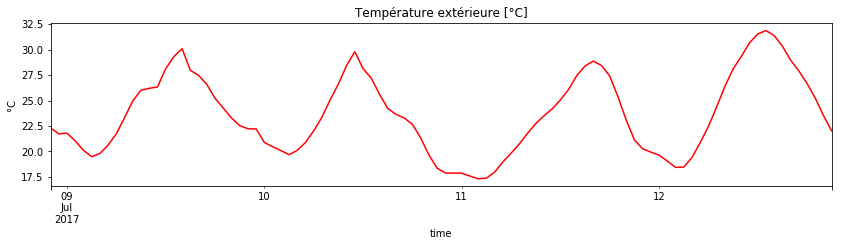

In [265]:
data['temperature'].plot(figsize=(14, 3), color='r' );  plt.ylabel('°C'); plt.title('Température extérieure [°C]');

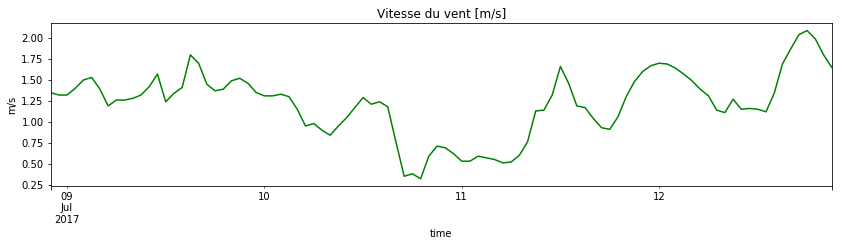

In [266]:
data['windSpeed'].plot(figsize=(14, 3), color='g' ); plt.ylabel('m/s'); plt.title('Vitesse du vent [m/s]');

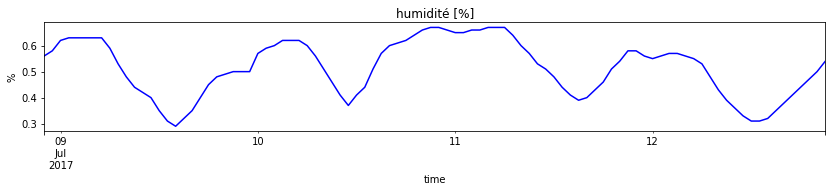

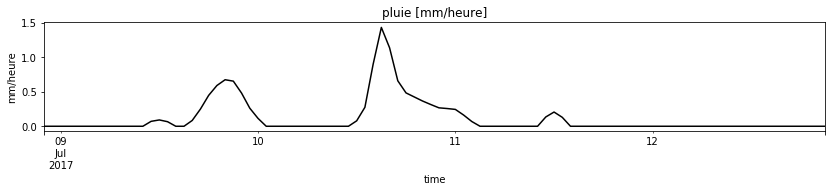

In [267]:
plt.figure()
data['humidity'].plot(figsize=(14, 2), color='b' ); plt.ylabel('%'); plt.title('humidité [%]');

plt.figure()
data['precipIntensity'].plot(figsize=(14, 2), color='k' ); plt.ylabel('mm/heure'); plt.title('pluie [mm/heure]');

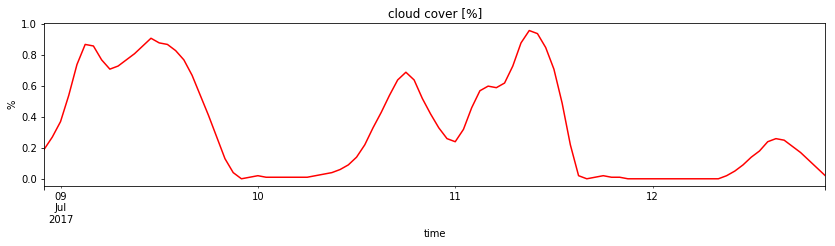

In [268]:
data['cloudCover'].plot(figsize=(14, 3), color='r' ); plt.ylabel('%'); plt.title('cloud cover [%]');

# Irradiation solaire

Le flux solaire est calculé à partir de la position du soleil dans le ciel, de l'épaisseur de la couche d'air traversée, de l'ombre des montagnes sur l'horizon, de la couverture nuageuse et enfin de l'orientation du toit. 

Une librairie python () permet d'obtenir 

In [269]:
sundata = sun.buildmultidayDF( coords_gps, data.index, cloudCover = data['cloudCover']  )

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


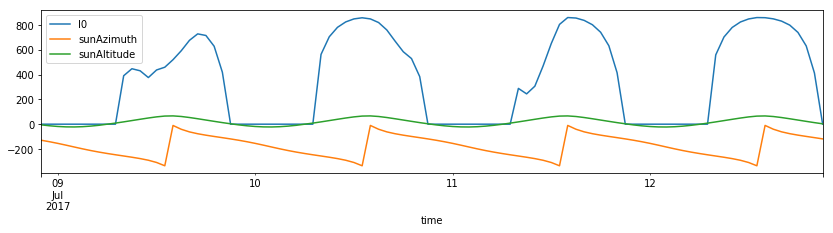

In [270]:
sundata.plot( figsize=(14, 3) )

### Projection sur les surfaces du toît

In [271]:
sigma = 37  # deg, angle du toit par rapport à l'horizontale
phi_C_bastille = 50  # deg, azimuth du toit
phi_C_vercors = 50+180  # deg, azimuth du toit

data['flux_bastille'] = sun.projectDF( sigma, phi_C_bastille, sundata )
data['flux_vercors'] =  sun.projectDF( sigma, phi_C_vercors, sundata )

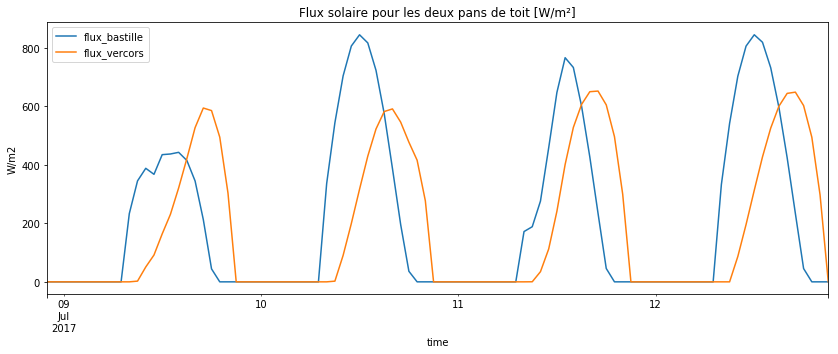

In [272]:
data[['flux_bastille', 'flux_vercors']].plot(figsize=(14, 5) )
plt.ylabel('W/m2');  plt.title('Flux solaire pour les deux pans de toit [W/m²]');

# Grandeurs physiques

In [273]:
sigmaSB = 5.670373e-8 # Constante de Stefan-Boltzmann,   W.m-2.K-4

In [274]:
albedo_tuile = 0.36  # Coef. de reflexion tuiles
emissivite_tuile = 0.92

In [275]:
""" Fonction du coefficient d'échange pour la convection thermique
"""
def coef_echange( vitesse_vent ):
    # vitesse_vent: m/s
    
    k = 0.0262 # W/m/K, conductivité thermique
    nu = 1.57e-5 #  m2.s−1 , viscosité cinématique air
    Pr = 0.708 # Prandl
    
    L = 4 # m, taille caractéristique, toit ou tuile ?
    
    Reynolds = vitesse_vent*L/nu
    
    if Reynolds > 3e5:
        # convection forcée, turbulent, Pr < 50  (cf. page 15)
        h = k/L * 0.036 *  Reynolds**(4/5) * Pr**(1/3)
    else:
        # convection naturelle
        h = 5
    
    return h

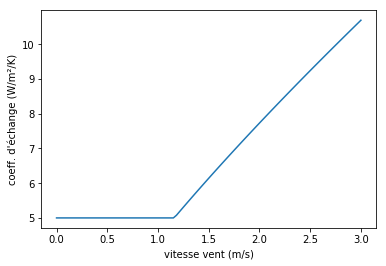

In [276]:
v_span = np.linspace( 0, 3, 100 )
h_span = [ coef_echange( v ) for v in v_span ]

plt.plot( v_span, h_span ); plt.xlabel('vitesse vent (m/s)');plt.ylabel("coeff. d'échange (W/m²/K)");

In [277]:
""" Rayonement thermique nocture vers le ciel
"""


def Goforth_skyrad( cloudCover, Tair_deg, RH ):
    """ Power radiated by the night sky
        see:  https://physics.stackexchange.com/q/153947
        https://physics.stackexchange.com/questions/153839/
        what-is-the-temperature-of-the-clear-night-sky-from-the-surface-of-earth
        "Cloud effects on thermal downwelling sky radiance," AeroSense 2002
    """
    K = 0.2 #0.34 for very low clouds to 0.06 for very high clouds,
    T = Tair_deg + 273
    RH = RH*100

    Pthermal = ( 1 + K*cloudCover**2 ) * 8.78e-13 * T**5.852 * RH**0.07195
    
    return Pthermal

## Modèle avec le rayonement du toit

$$
h(t)\,( T_{air}  - T  ) + (1-\alpha)\, \Phi(t) - \sigma_B \, \epsilon \, T^4 + P_{ciel}(t) = 0
$$

In [278]:
from scipy.optimize import brentq

In [279]:
def model02_apply( datarow, flux_name=None, disp=False  ):
    
    
    # Flux directe soleil :
    flux_soleil = datarow[ flux_name ]
    rayonement_soleil = (1 - albedo_tuile) * flux_soleil
    
    # Convection :
    T_air = datarow['temperature']
    h = coef_echange( datarow['windSpeed'] )   
    
    convection = lambda T:  h * ( T_air - T )
    
    # Rayonement 
    rayonement_toit = lambda T: -sigmaSB * emissivite_tuile * ( T + 273 )**4
    
    rayonement_ciel = Goforth_skyrad( datarow['cloudCover'], T_air, datarow['humidity']  )
    
    # Somme:
    somme_flux = lambda T: convection(T) + rayonement_toit(T) + rayonement_soleil + rayonement_ciel
    
    # Resolution numérique du zéro:
    Tmin, Tmax = -50, 200
    T_eq = brentq(somme_flux, Tmin, Tmax)
    
    if disp:
        print( convection(T_eq), rayonement_toit(T_eq), rayonement_soleil, rayonement_ciel )
    
    return T_eq

In [280]:
Ttuile = {}
Ttuile['bastille'] = data.apply(model02_apply, axis=1, flux_name='flux_bastille')
Ttuile['vercors'] = data.apply(model02_apply, axis=1, flux_name='flux_vercors')

Ttuile = pd.DataFrame(Ttuile)

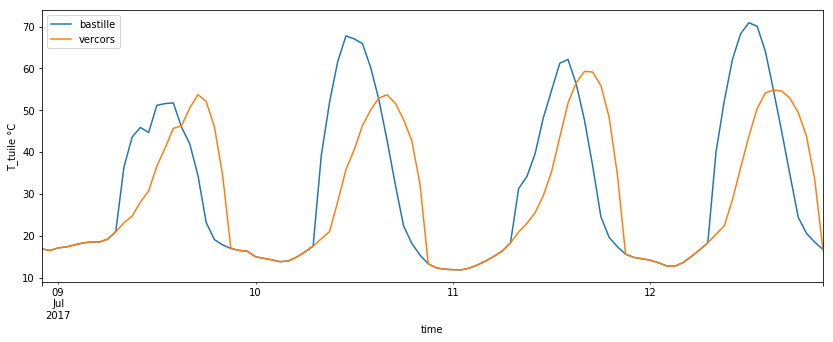

In [281]:
Ttuile.plot(figsize=(14, 5) ); plt.ylabel('T_tuile °C');

In [249]:
# Pour voir la repartition :
row = data.to_dict(orient='index')[pd.to_datetime( '27/06/2017 20h00' ) ]
model02_apply( row, flux_name='flux_bastille' , disp=True )

1.97569000611 -402.9060409875023 0.0 400.930350981


23.449744884013803

In [250]:
# Zoom
zoom_start = pd.to_datetime( '28/06/2017' ) 
mask = (data.index > zoom_start)

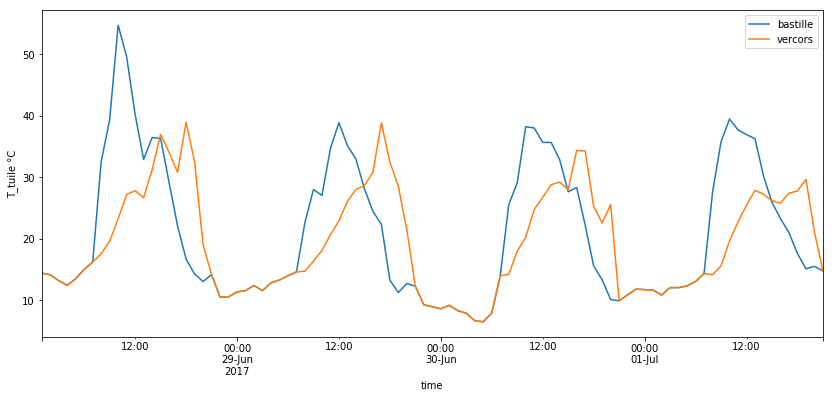

In [251]:
Ttuile.loc[mask].plot(figsize=(14, 6) ); plt.ylabel('T_tuile °C');

### Remarques
- 'true' temperature du ciel
- Radiation diffuse ? same as sky temp ?
- Prise en compte de la pluie ... ?
- Effet des velux ?
- Pour le mur vertical ? 

- La nuit Ttuile < T_air ... ? condensation ? convection inversée...

# Validation du modèle

La mesure est effectuée manuellement avec thermomètre infrarouge. 

In [260]:
mesures = pd.read_csv('mesures/mesures_Ttuiles.csv', sep=';', index_col=2, parse_dates=True, decimal=',' )
mesures = mesures.drop(['Unnamed: 0', 'Unnamed: 1'], 1)

In [261]:
# Zoom
zoom_start = pd.to_datetime( '27/06/2017' ) 
mask = (data.index > zoom_start)

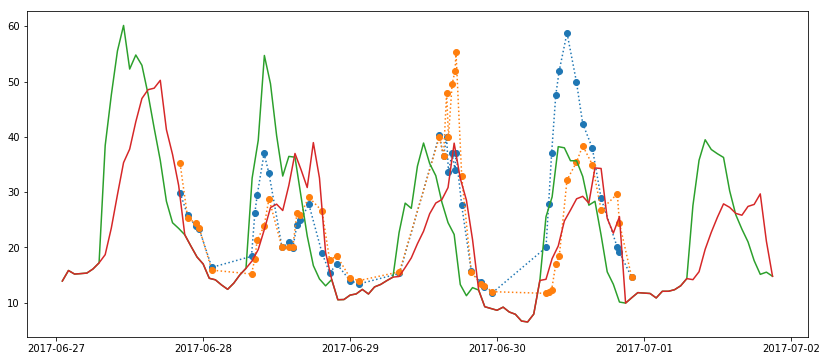

In [262]:
plt.figure( figsize=(14, 6) )
plt.plot( mesures, ':o' )
plt.plot( Ttuile.loc[mask], '-' );

La valeur de la couverture nuageuse est determinante... mieux 